# Example of upper limit computation.

In [1]:
from statnight import Hypothesis, Observable, Constant, Variable
from statnight.calculators import AsymptoticCalculator
from statnight.utils.pdf import Gaussian, gaussian, exponential
from scipy.stats import expon
from statnight.utils.stats import integrate1d
import numpy as np
import matplotlib.pyplot as plt
import iminuit
import math

## Scenario

Let's assume you want to find a resonnance between 0.1 and 3.0 GeV/c$^2$ of invariant mass of a system.

You have a signal region and a background only region:

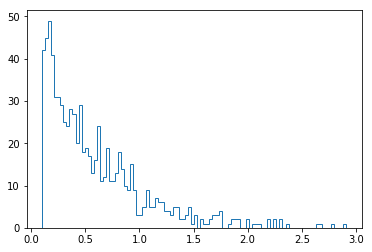

In [2]:
bounds = (0.1,3.0)

#background only
np.random.seed(10)
tau = 2.0
beta = 1./tau
data = np.random.exponential(beta, 1000)

data_bkg = data[(data > bounds[0]) & (data < bounds[1])]
plt.hist(data_bkg, bins=100, histtype='step');

In [3]:
#signal + background

np.random.seed(0)
tau = -2.0
beta = -1/tau
data = np.random.exponential(beta, 300)
peak = np.random.normal(1.2, 0.1, 4)
data = np.concatenate((data,peak))
data = data[(data > 0.1) & (data < 3)]

### Background fit, in background only region:

The background model is an exponential.

In [4]:
#NBVAL_CHECK_OUTPUT
def exp_normalized(x, tau):
    ret = exponential(x, tau)
    norm = exponential.integrate(bounds, 100, tau)
    return ret/norm

model_bkg = Model(exp_normalized)
model_bkg.add_obs(Observable("x", range = bounds))
tau = Variable("tau",   range=(0.1, 5.0), initvalue=0.5,       initstep=0.05)
model_bkg.add_vars(tau)

lh_bkg = model_bkg.nll_function(data_bkg)

params = tau.tominuit()

minuit_bkg = iminuit.Minuit(lh_bkg, pedantic=True, errordef=0.5, **params)

NameError: name 'Model' is not defined

In [ ]:
minuit_bkg.migrad();

### Signal + background fit in signal region:

The total model is a sum of a gaussian and an exponential. The tau parameter of the exponential will be constrained to the value obtained in the background only region.

In [ ]:
def gauss_normalized(x, mu, sigma):  
    ret = gaussian(x, mu, sigma)
    norm = gaussian.integrate(bounds, 100, mu, sigma)
    return ret/ norm

def exp_extended(x, tau, Nbkg):  
    ret = exp_normalized(x, tau)
    return ret * Nbkg

def gauss_extended(x, mu, sigma, Nsig):  
    ret = gauss_normalized(x, mu, sigma)
    return ret * Nsig

def totpdf(x, mu, sigma, Nsig, tau, Nbkg):
    ret  = gauss_extended(x, mu, sigma, Nsig)
    ret += exp_extended(x, tau, Nbkg)
    return ret

#### Model definition:

Construct a model from a given probability density function (pdf) and then assign which parameters of the pdf are observables or variables/constants and initialize them.

Observable and Variable require a name and a range. Optional arguments can be given to Variable such as an initial value and initial step for minuit, and constraint wich is a function.
Constant only require a name and a value.

In [ ]:
model_sb = Model(totpdf)

model_sb.add_obs(Observable("x", range = bounds))

mean  = Constant("mu",  value=1.2)
sigma = Constant("sigma", value= 0.1)
Nsig  = Variable("Nsig",  range=(-10,len((data))),   initvalue= 0.0,       initstep=1.0)
tau_constraint = Gaussian(mean = minuit_bkg.values["tau"], sigma = minuit_bkg.errors["tau"])
tau   = Variable("tau",   range=(0.1, 5.0), initvalue=0.5, initstep=0.05, constraint=tau_constraint)
Nbkg  = Variable("Nbkg",  range=(0,len((data))*1.1), initvalue= len(data), initstep=1.0)

model_sb.add_vars([mean, sigma, Nsig, tau, Nbkg])

model_sb.add_ext_pars(["Nsig","Nbkg"])

In [ ]:
model_sb.variables

In [ ]:
lh_sb = model_sb.nll_function(data)

params = {}
for v in model_sb.variables:
    params.update(v.tominuit())

minuit_sb = iminuit.Minuit(lh_sb, pedantic=True, errordef=0.5, **params)

In [ ]:
minuit_sb.migrad();

In [ ]:
def plotfitresult(pdf, bounds, nbins, *args):
    x = np.linspace(bounds[0], bounds[1], nbins)
    bin_centers = x[:-1] + np.diff(x)/2.
    y = np.zeros(bin_centers.shape)
    
    for i in range(nbins-1):
        y[i] = integrate1d(pdf, (x[i],x[i+1]), 100, *args)
        
    plt.plot(bin_centers, y, "-r")      

In [ ]:
nbins = 100
fit_result = minuit_sb.values.values()
plt.hist(data, bins=nbins, histtype='step', range=bounds);
plotfitresult(totpdf, bounds, nbins, *fit_result)

The number of signal events is consistent with zero, let's compute now an upper limit for this model.

## Upper limit:

In [ ]:
null_hypothesis = model_sb.create_hypothesis({"Nsig":np.linspace(0.1, 12, 60)})
null_hypothesis.summary()

In [ ]:
alt_hypothesis = model_sb.create_hypothesis({"Nsig":0})
alt_hypothesis.summary()

In [ ]:
calc = AsymptoticCalculator(null_hypothesis, alt_hypothesis, data)
calc.qtilde = False
calc.CLs = True
calc.bestfitpoi = minuit_sb.values["Nsig"]

In [ ]:
ul = calc.upperlimit()

In [ ]:
calc.plot()